In [1]:
import torch # import pytorch
print("Pytorch Version:", torch.__version__)
print("GPU avaliable:", torch.cuda.is_available())
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

Pytorch Version: 0.4.0
GPU avaliable: True


In [2]:
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as trans
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from utils0 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

In [4]:
# load a pretrained generator
G_d = dc_generator()
G_d.load_state_dict(torch.load('./savemodels/pretrained_gan_64/G_9000.pkl'))
G_d = G_d.type(dtype)
for param in G_d.parameters():
    param.requires_grad = False

In [5]:
def show_images_inline(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.transpose(1, 2, 0))
    return

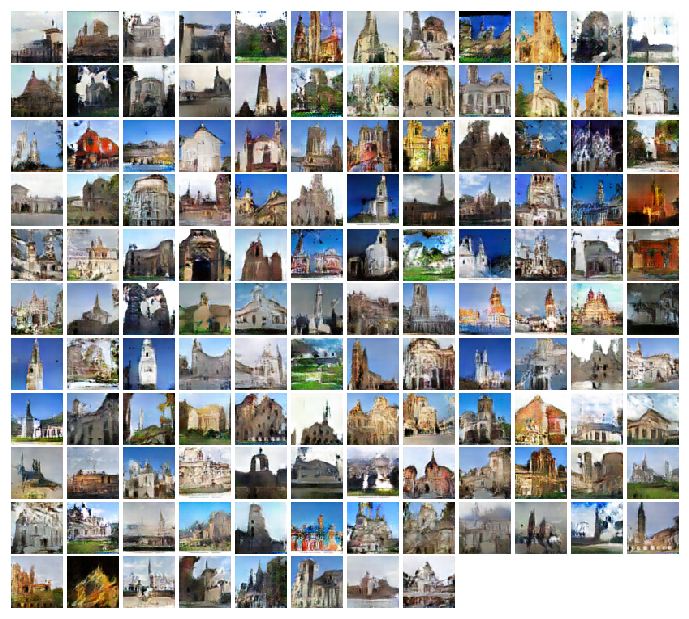

In [6]:
g_fake_seed = sample_noise(128, 100).type(dtype)
fake_images = G_d(g_fake_seed)
imgs_numpy = deprocess_img(fake_images.cpu().detach().numpy())
show_images_inline(imgs_numpy[0:128])

In [8]:
loss_net = torchvision.models.squeezenet1_1(pretrained=True).features
loss_net.type(dtype)

for param in loss_net.parameters():
    param.requires_grad = False

for param_tensor in loss_net.state_dict():
    print(param_tensor, "\t", loss_net.state_dict()[param_tensor].size())

0.weight 	 torch.Size([64, 3, 3, 3])
0.bias 	 torch.Size([64])
3.squeeze.weight 	 torch.Size([16, 64, 1, 1])
3.squeeze.bias 	 torch.Size([16])
3.expand1x1.weight 	 torch.Size([64, 16, 1, 1])
3.expand1x1.bias 	 torch.Size([64])
3.expand3x3.weight 	 torch.Size([64, 16, 3, 3])
3.expand3x3.bias 	 torch.Size([64])
4.squeeze.weight 	 torch.Size([16, 128, 1, 1])
4.squeeze.bias 	 torch.Size([16])
4.expand1x1.weight 	 torch.Size([64, 16, 1, 1])
4.expand1x1.bias 	 torch.Size([64])
4.expand3x3.weight 	 torch.Size([64, 16, 3, 3])
4.expand3x3.bias 	 torch.Size([64])
6.squeeze.weight 	 torch.Size([32, 128, 1, 1])
6.squeeze.bias 	 torch.Size([32])
6.expand1x1.weight 	 torch.Size([128, 32, 1, 1])
6.expand1x1.bias 	 torch.Size([128])
6.expand3x3.weight 	 torch.Size([128, 32, 3, 3])
6.expand3x3.bias 	 torch.Size([128])
7.squeeze.weight 	 torch.Size([32, 256, 1, 1])
7.squeeze.bias 	 torch.Size([32])
7.expand1x1.weight 	 torch.Size([128, 32, 1, 1])
7.expand1x1.bias 	 torch.Size([128])
7.expand3x3.weight 	

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [ ]:
# style utils
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def style_target_preprocess(style_target, size=512, batchsize=128):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x.repeat(batchsize, 1, 1, 1)),
    ])
    return transform(style_target)

